In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3
import os
import sys

# Add project root to path (for Jupyter notebooks)
# Get the current directory and navigate to project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, project_root)

from app.config import Config
from app.services import EDA
from app.services import PresentValue

%load_ext autoreload
%autoreload 2
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pv = PresentValue()
anual_increment = pv.fetch_incremento_from_database()

In [23]:
def get_head(df: pd.DataFrame) -> pd.DataFrame:
    df_head = df.iloc[ 0:15 , 0:2 ]
    df_head = pd.DataFrame([df_head.iloc[:,1].to_list()], columns=df_head.iloc[:,0].to_list())

    # Assign dtypes: categorical, string, and numeric
    str_cols = [ "NOMBRE DEL PROYECTO"]
    int_cols = [ "AÑO INICIO"]

    df_head[str_cols] = df_head[str_cols].astype("string")
    df_head[int_cols] = df_head[int_cols].astype("Int64")
    
    return df_head.loc[:, ['NOMBRE DEL PROYECTO', 'CÓDIGO DEL PROYECTO', 'AÑO INICIO', 'FASE', 'DEPARTAMENTO']]

def get_uf(df: pd.DataFrame) -> pd.DataFrame:
    df_uf = df.iloc[0:11,3:].iloc[ : , :-1 ]
    column_names = (df_uf.iloc[1:, 0].astype(str) + " " + df_uf.iloc[1:, 1].astype(str)).to_list()
    column_names = [column.replace(" nan", "") for column in column_names]
    df_uf = df_uf.drop(df_uf.columns[[1]], axis=1)
    
    return df_uf, column_names

def get_items(df: pd.DataFrame) -> pd.DataFrame:
    # Detect phase from the FASE field
    fase = str(df.iloc[3, 1]) if df.shape[0] > 3 and df.shape[1] > 1 else ""
    
    # Define column names based on phase
    if 'Fase I - Prefactibilidad' in fase:
        # Fase I - Prefactibilidad columns
        columns_names_items = [
            "1 - TRANSPORTE", "2 - DISEÑO GEOMÉTRICO", "3 - PREFACTIBILIDAD TÚNELES",
            "4 - GEOLOGIA", "5 - GEOTECNIA", "6 - HIDROLOGÍA E HIDRÁULICA", "7 - AMBIENTAL Y SOCIAL",
            "8 - PREDIAL", "9 - RIESGOS Y SOSTENIBILIDAD", "10 - EVALUACIÓN ECONÓMICA", 
            "11 - SOCIO ECONÓMICA, FINANCIERA", "12 - ESTRUCTURAS", "13 - DIRECCIÓN Y COORDINACIÓN"
        ]
    elif 'Fase II - Factibilidad' in fase:
        # Fase II - Factibilidad columns (main items only, no subcomponents)
        columns_names_items = [
            "1 - TRANSPORTE", "2 - TRAZADO Y TOPOGRAFIA", "2.1 - INFORMACIÓN GEOGRÁFICA", "2.2 TRAZADO Y DISEÑO GEOMÉTRICO",
            "3 - GEOLOGÍA", "3.1 - GEOLOGÍA", "3.2 - HIDROGEOLOGÍA", "4 - TALUDES", "5 - HIDROLOGÍA E HIDRÁULICA",
            "6 - ESTRUCTURAS", "7 - TÚNELES", "8 - PAVIMENTO", "9 - PREDIAL",
            "10 - AMBIENTAL Y SOCIAL", "11 - COSTOS Y PRESUPUESTOS", "12 - SOCIOECONÓMICA", "13 - DIRECCIÓN Y COORDINACIÓN"
        ]
    else:
        # Fase III - Diseños a detalle (default)
        columns_names_items = [
            "1 - TRANSPORTE", "2 - TRAZADO Y DISEÑO GEOMÉTRICO", 
            "2.1 - INFORMACIÓN GEOGRÁFICA", "2.2 TRAZADO Y DISEÑO GEOMÉTRICO", "2.3 - SEGURIDAD VIAL",
            "2.4 - SISTEMAS INTELIGENTES", "3 - GEOLOGÍA", "3.1 - GEOLOGÍA", "3.2 - HIDROGEOLOGÍA",
            "4 - SUELOS", "5 - TALUDES", "6 - PAVIMENTO", "7 - SOCAVACIÓN", "8 - ESTRUCTURAS",
            "9 - TÚNELES", "10 - URBANISMO Y PAISAJISMO", "11 - PREDIAL", "12 - IMPACTO AMBIENTAL",
            "13 - CANTIDADES", "14 - EVALUACIÓN SOCIOECONÓMICA", "15 - OTROS - MANEJO DE REDES",
            "16 - DIRECCIÓN Y COORDINACIÓN"
        ]
    
    # Extract item data (starting from row 17, columns 0-1, taking only column 1 values)
    df_items = df.iloc[17:, 0:2]
    
    # Create a row with the values, padded/truncated to match column count
    values = df_items.iloc[:, 1].to_list()
    
    df_items = pd.DataFrame([values], columns=columns_names_items)
    
    return df_items


In [24]:
def assemble_sheet(df: pd.DataFrame) -> pd.DataFrame:

    df_head = get_head(df)
    df_uf, column_names = get_uf(df)
    df_items = get_items(df)
    rows = []
    
    #Create a row for each functional unit
    for i in range(1, df_uf.shape[1]):
        
        #Aggregate longitud, puentes, tuneles for the current functional unit
        df_uf_x = pd.DataFrame([df_uf.iloc[1:,i].to_list()], columns=column_names)  
        df_uf_x['NOMBRE UF'] = df_uf.iloc[0, i]
        
        df_items_for_functional_unit = df_items / 1 # Future consideration divide  by df_uf_totals
        
        row = pd.concat([df_head, df_uf_x, df_items_for_functional_unit], axis=1)
        rows.append(row)
        
    return pd.concat(rows, axis=0, ignore_index=True)


In [25]:
def assemble_project(filename: str) -> pd.DataFrame:
    with pd.ExcelFile(filename, engine="openpyxl") as xls:
        
        project_names = [project_name for project_name in xls.sheet_names if project_name.isnumeric()]
        df_project =[]

        for project_name in project_names:
            df = pd.read_excel(filename, sheet_name=project_name, header=None, engine="openpyxl")
            df_project.append(assemble_sheet(df))
            #TEMPORAL DEBUGGING
            if project_name == '45000036221':
                break 

    return pd.concat(df_project, axis=0, ignore_index=True)



In [26]:
filename = "../data/BASE DE DATOS PRESUPUESTOS.xlsx"
assemble_project(filename)

,NOMBRE DEL PROYECTO,CÓDIGO DEL PROYECTO,AÑO INICIO,FASE,DEPARTAMENTO,LONGITUD KM,PUENTES VEHICULARES UND,PUENTES VEHICULARES M2,PUENTES PEATONALES UND,PUENTES PEATONALES M2,...,4 - TALUDES,5 - HIDROLOGÍA E HIDRÁULICA,6 - ESTRUCTURAS,7 - TÚNELES,8 - PAVIMENTO,9 - PREDIAL,10 - AMBIENTAL Y SOCIAL,11 - COSTOS Y PRESUPUESTOS,12 - SOCIOECONÓMICA,13 - DIRECCIÓN Y COORDINACIÓN
0,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,26.2,14,4138.56,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
1,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,23.8,19,10311.40,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
2,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,24.9,7,1897.26,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
3,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,14.6,9,8428.80,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
4,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,49.4,33,11141.76,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
5,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,40.8,67,47596.30,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0
6,AUTOPISTAS DE LA MONTAÑA,45000036221,2010,Fase II - Factibilidad,ANTIOQUIA - CALDAS Y RISARALDA,26.4,40,39907.20,0,0,...,139616991.0,0.0,5761233.0,252607720.0,25858300.0,122586050.0,302592911.0,46610370.0,0.0,95956539.0


In [16]:
def weighted_values(row: pd.Series) -> pd.Series:

    row = row.fillna(0)

    #Longitude analysis
    longitude_weigth = row['LONGITUD KM WEIGHT']
    row['1 - TRANSPORTE'] *= longitude_weigth
    row['2 - TRAZADO Y DISEÑO GEOMÉTRICO'] *= longitude_weigth
    row['2.1 - INFORMACIÓN GEOGRÁFICA'] *= longitude_weigth
    row['2.2 TRAZADO Y DISEÑO GEOMÉTRICO'] *= longitude_weigth
    row['2.3 - SEGURIDAD VIAL'] *= longitude_weigth
    row['2.4 - SISTEMAS INTELIGENTES'] *= longitude_weigth
    row['3 - GEOLOGÍA'] *= longitude_weigth   
    row['3.1 - GEOLOGÍA'] *= longitude_weigth
    row['3.2 - HIDROGEOLOGÍA'] *= longitude_weigth

    row['5 - TALUDES'] *= longitude_weigth
    row['6 - PAVIMENTO'] *= longitude_weigth
    row['7 - SOCAVACIÓN'] *=     longitude_weigth

    row['11 - PREDIAL'] *= longitude_weigth
    row['12 - IMPACTO AMBIENTAL'] *= longitude_weigth

    row['15 - OTROS - MANEJO DE REDES'] *= longitude_weigth
    
    #Bridge analysis
    bridge_weigth = 1
    if row['PUENTES VEHICULARES UND'] > 0 or row['PUENTES PEATONALES UND'] > 0:
        bridges_ratio = 3
        bridge_weigth = ((row['PUENTES VEHICULARES UND WEIGHT'] + row['PUENTES VEHICULARES M2 WEIGHT'])*bridges_ratio + row['PUENTES PEATONALES UND WEIGHT'])/bridges_ratio*3
        row['4 - SUELOS'] *= bridge_weigth
        row['8 - ESTRUCTURAS'] *= bridge_weigth
    
    #Tunnel analysis
    tunnel_weight = 1
    if row['TUNELES UND'] > 0:
        tunnel_weight = row['TUNELES UND WEIGHT'] + row['TUNELES M2 WEIGHT']
        row['9 - TÚNELES'] *= tunnel_weight
    
    #Urbanism analysis
    urbanism_weight = 1
    if row['PUENTES PEATONALES UND'] > 0:  
        urbanism_weight = row['PUENTES PEATONALES UND WEIGHT']
        row['10 - URBANISMO Y PAISAJISMO'] *= urbanism_weight
    
    return row


In [14]:
def present_value_costs(row: pd.Series, mask: list[str], present_year: int) -> pd.Series:
    for col in mask:
        row[col] = pv.present_value(row[col], row['AÑO INICIO'], present_year) 
    return row

In [ ]:
def load_dataframe_from_database(database_path: str = None) -> pd.DataFrame:

    from app.config import Config
    
    if database_path is None:
        database_path = Config.OLD_DATABASE
    
    # Mapping from database field names to Excel column names
    item_field_to_excel = {
        'transporte': '1 - TRANSPORTE',
        'informacion_geografica': '2.1 - INFORMACIÓN GEOGRÁFICA',
        'trazado_diseno_geometrico': '2.2 TRAZADO Y DISEÑO GEOMÉTRICO',
        'seguridad_vial': '2.3 - SEGURIDAD VIAL',
        'sistemas_inteligentes': '2.4 - SISTEMAS INTELIGENTES',
        'geologia': '3.1 - GEOLOGÍA',
        'hidrogeologia': '3.2 - HIDROGEOLOGÍA',
        'suelos': '4 - SUELOS',
        'taludes': '5 - TALUDES',
        'pavimento': '6 - PAVIMENTO',
        'socavacion': '7 - SOCAVACIÓN',
        'estructuras': '8 - ESTRUCTURAS',
        'tuneles': '9 - TÚNELES',
        'urbanismo_paisajismo': '10 - URBANISMO Y PAISAJISMO',
        'predial': '11 - PREDIAL',
        'impacto_ambiental': '12 - IMPACTO AMBIENTAL',
        'cantidades': '13 - CANTIDADES',
        'evaluacion_socioeconomica': '14 - EVALUACIÓN SOCIOECONÓMICA',
        'otros_manejo_redes': '15 - OTROS - MANEJO DE REDES',
        'direccion_coordinacion': '16 - DIRECCIÓN Y COORDINACIÓN'
    }
    
    # Connect to database
    conn = sqlite3.connect(database_path)
    
    # Query to join all three tables
    query = """
    SELECT 
        p.nombre AS 'NOMBRE DEL PROYECTO',
        p.codigo AS 'CÓDIGO DEL PROYECTO',
        p.anio_inicio AS 'AÑO INICIO',
        p.fase AS 'FASE',
        p.ubicacion AS 'DEPARTAMENTO',
        uf.longitud_km AS 'LONGITUD KM',
        uf.puentes_vehiculares_und AS 'PUENTES VEHICULARES UND',
        uf.puentes_vehiculares_mt2 AS 'PUENTES VEHICULARES M2',
        uf.puentes_peatonales_und AS 'PUENTES PEATONALES UND',
        uf.puentes_peatonales_mt2 AS 'PUENTES PEATONALES M2',
        uf.tuneles_und AS 'TUNELES UND',
        uf.tuneles_km AS 'TUNELES KM',
        uf.alcance AS 'ALCANCE',
        uf.zona AS 'ZONA',
        uf.tipo_terreno AS 'TIPO TERRENO',
        'UF' || uf.unidad_funcional AS 'NOMBRE UF',
        i.transporte,
        i.informacion_geografica,
        i.trazado_diseno_geometrico,
        i.seguridad_vial,
        i.sistemas_inteligentes,
        i.geologia,
        i.hidrogeologia,
        i.suelos,
        i.taludes,
        i.pavimento,
        i.socavacion,
        i.estructuras,
        i.tuneles,
        i.urbanismo_paisajismo,
        i.predial,
        i.impacto_ambiental,
        i.cantidades,
        i.evaluacion_socioeconomica,
        i.otros_manejo_redes,
        i.direccion_coordinacion
    FROM proyectos p
    INNER JOIN unidad_funcional uf ON p.codigo = uf.codigo
    INNER JOIN item i ON p.codigo = i.codigo
    ORDER BY p.codigo, uf.unidad_funcional
    """
    
    # Load data into dataframe
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Rename item columns to match Excel format
    for db_field, excel_col in item_field_to_excel.items():
        if db_field in df.columns:
            df.rename(columns={db_field: excel_col}, inplace=True)
    
    # Reorder columns to match original structure
    column_order = [
        'NOMBRE DEL PROYECTO', 'CÓDIGO DEL PROYECTO', 'AÑO INICIO', 'FASE', 'DEPARTAMENTO',
        'LONGITUD KM', 'PUENTES VEHICULARES UND', 'PUENTES VEHICULARES M2',
        'PUENTES PEATONALES UND', 'PUENTES PEATONALES M2', 'TUNELES UND', 'TUNELES KM',
        'ALCANCE', 'ZONA', 'TIPO TERRENO', 'NOMBRE UF',
        '1 - TRANSPORTE', '2.1 - INFORMACIÓN GEOGRÁFICA', '2.2 TRAZADO Y DISEÑO GEOMÉTRICO',
        '2.3 - SEGURIDAD VIAL', '2.4 - SISTEMAS INTELIGENTES',
        '3.1 - GEOLOGÍA', '3.2 - HIDROGEOLOGÍA', '4 - SUELOS', '5 - TALUDES',
        '6 - PAVIMENTO', '7 - SOCAVACIÓN', '8 - ESTRUCTURAS', '9 - TÚNELES',
        '10 - URBANISMO Y PAISAJISMO', '11 - PREDIAL', '12 - IMPACTO AMBIENTAL',
        '13 - CANTIDADES', '14 - EVALUACIÓN SOCIOECONÓMICA',
        '15 - OTROS - MANEJO DE REDES', '16 - DIRECCIÓN Y COORDINACIÓN'
    ]
    
    # Only include columns that exist in the dataframe
    column_order = [col for col in column_order if col in df.columns]
    df = df[column_order]
    
    return df

In [18]:
def remove_outliers(df, target='2.2 TRAZADO Y DISEÑO GEOMÉTRICO'):
    q1, q3 = df[target].quantile(0.05), df[target].quantile(0.95)
    iqr = q3 - q1
    x_clean = (df[target] >= q1 - 1.5*iqr) & (df[target] <= q3 + 1.5*iqr) & (df[target] != 0)
    
    df_clean = df[x_clean]
    return df_clean

In [28]:
def create_dataset(present_value_costs) -> pd.DataFrame:
    
    # df = assemble_project()
    df = load_dataframe_from_database()

    mask = df.columns[df.columns.str.match(r"^\d")].tolist()
    df_present_value = df.apply(present_value_costs, axis=1, mask=mask, present_year=2025)
    df = df_present_value.drop(columns=['AÑO INICIO', 'NOMBRE UF'])

    cols = df.loc[:, 'LONGITUD KM':'TUNELES M2'].columns
    totals = df.groupby('NOMBRE DEL PROYECTO')[cols].transform('sum').replace(0, pd.NA)
    w = (df[cols] / totals).fillna(0)
    w.columns = [f'{c} WEIGHT' for c in cols]
    df = df.join(w)
    df =df.apply(weighted_values, axis=1)
    df = df.drop(columns=['NOMBRE DEL PROYECTO'])
    df = df.loc[:, 'LONGITUD KM':'16 - DIRECCIÓN Y COORDINACIÓN']
    
    return df

In [29]:
df = create_dataset(pv.present_value_costs)
df

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [13]:
df_clean = remove_outliers(df)[['LONGITUD KM', 'ALCANCE', '2.2 TRAZADO Y DISEÑO GEOMÉTRICO']]

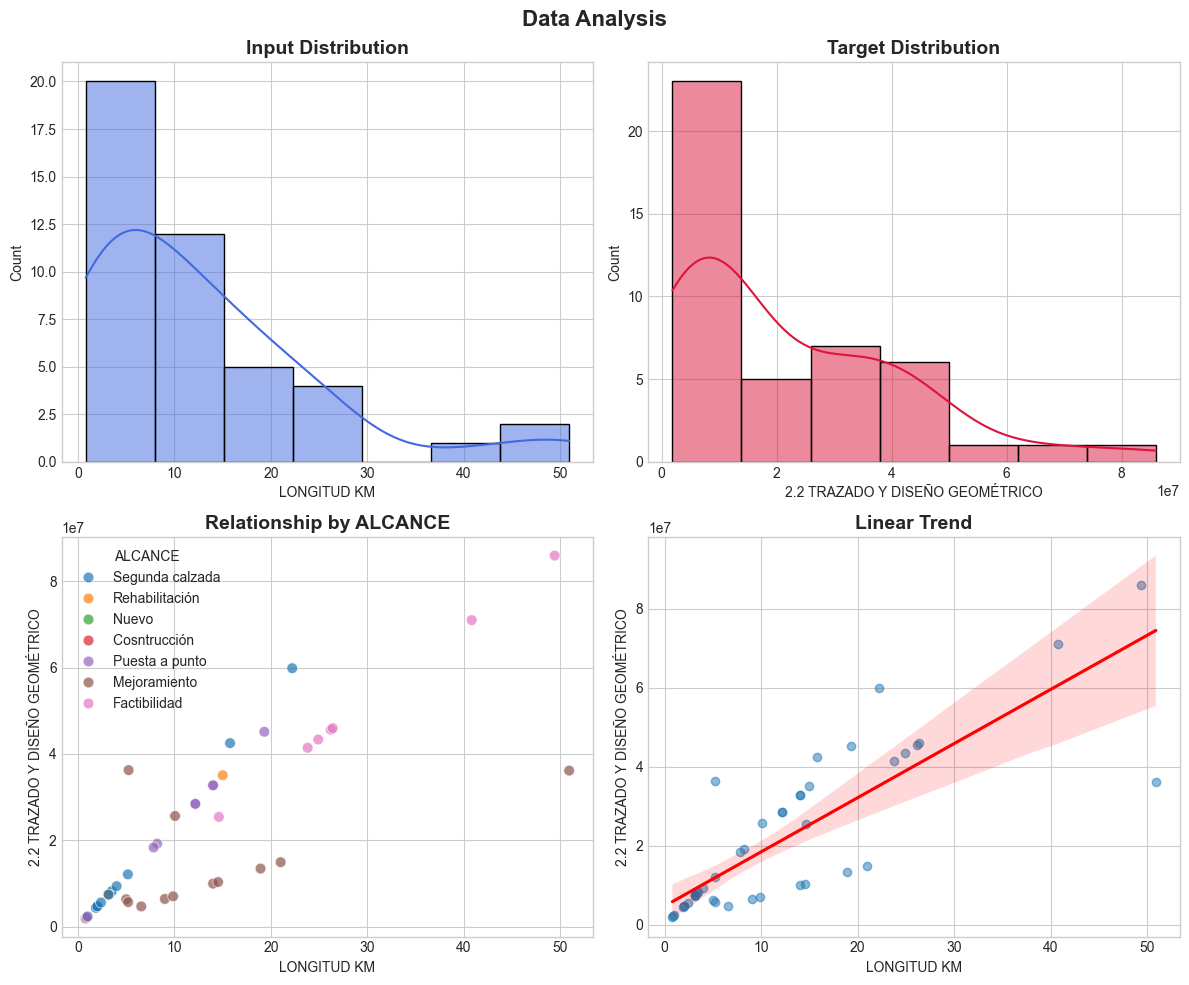

In [14]:
predictor_name = 'LONGITUD KM'
target_name = '2.2 TRAZADO Y DISEÑO GEOMÉTRICO'
hue_name = 'ALCANCE'

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Input distribution
sns.histplot(df_clean[predictor_name], kde=True, ax=axes[0,0], color='royalblue')
axes[0,0].set_title('Input Distribution', fontsize=14, weight='bold')

# Output distribution  
sns.histplot(df_clean[target_name], kde=True, ax=axes[0,1], color='crimson')
axes[0,1].set_title('Target Distribution', fontsize=14, weight='bold')

# Scatter by category
sns.scatterplot(data=df_clean, x=predictor_name, y=target_name, hue=hue_name, ax=axes[1,0], s=60, alpha=0.7)
axes[1,0].set_title(f'Relationship by {hue_name}', fontsize=14, weight='bold')

# Joint plot with regression
sns.regplot(data=df_clean, x=predictor_name, y=target_name, ax=axes[1,1], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[1,1].set_title('Linear Trend', fontsize=14, weight='bold')

plt.suptitle('Data Analysis', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()